<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2025/Practica_11_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 11: Modelos de Regresión Lineal Generalizada

En esta clase vamos a ver cómo cargar nuevos modelos de regresión en `Bambi`, yendo más allá y utilizando funciones de verosimilitud que no son Normales.

Nuestro caso de aplicación de ejemplo será la regresión logística, donde lo que vamos a ajutar es la probabilidad $p$ de pertencer a una determinada categoría, y esta probabilidad depende de distintos predictores.

*Nota: Nada me impediría aplicar estos conceptos, por ejemplo, a una distribución de Poisson donde $\lambda$ depende de $x$, a una binomial, etc.*

Empecemos importando las liberías necesarias.

In [1]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import io
from google.colab import files

## Ejercicio: Modelado de variables de respuesta categóricas

Para este ejercicio vamos a utilizar el archivo **concrete_test.csv** que contiene distintos ensayos de hormigón y su composición. En este ejemplo vamos a hacernos la siguiente pregunta:

- Si me dan las propiedades de un hormigón, ¿puedo identificar si continene escoria de alto horno o no?

Para contestar esa pregunta, lo que haremos será construir un modelo que prediga la probabilidad de contenter escoria en función de otras variables predictoras.

### Carga de Datos

In [3]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving concrete_tests.csv to concrete_tests.csv


In [4]:
#Se crea un DataFrame
df_hormigon = pd.read_csv(io.BytesIO(uploaded['concrete_tests.csv']))
df_hormigon.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [5]:
# Vemos el tipo de dato y si existen nulos
df_hormigon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [6]:
df_hormigon.rename(columns={
  'Fly ash': "Fly_ash",
  'SP': "Superplasticizer",
  'Coarse Aggr.': "Coarse_aggr",
  'Fine Aggr.': "Fine_aggr",
  'SLUMP(cm)': 'Slump_cm',
  'FLOW(cm)': 'Flow_cm',
  'Compressive Strength (28-day)(Mpa)': "CompressiveStrength"
                     },
            inplace=True)

### Ejemplo: Regresión logística

Primero, definiremos la variable categórica `escoria` que indica si hay presencia de escoria en la dosificación (`True`) o no (`False`). Luego, como sabemos que un parámetro fundamental de las dosificaciones de hormigón es la relación `agua-material cementicio`, crearemos la variable `a_c`.

In [7]:
# Nuevas Variables
df_hormigon['escoria'] = (df_hormigon['Slag']!=0)
df_hormigon['a_c'] = (df_hormigon['Water']/(df_hormigon['Cement']+df_hormigon['Fly_ash']+df_hormigon['Slag']))

df_hormigon.head()

,Cement,Slag,Fly_ash,Water,Superplasticizer,Coarse_aggr,Fine_aggr,Slump_cm,Flow_cm,CompressiveStrength,escoria,a_c
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99,True,0.456522
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14,True,0.357853
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81,True,0.357285
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08,True,0.358000
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82,True,0.536585


#### EDA

A fines didácticos, se presenta un simple pair-plot con las variables que se van a tener en cuenta en este problema:

- `a_c`: relación agua-material cementicio
- `slump_cm`: asentamiento de la muestra
- `CompressiveStrength`: resistencia a 28 días.

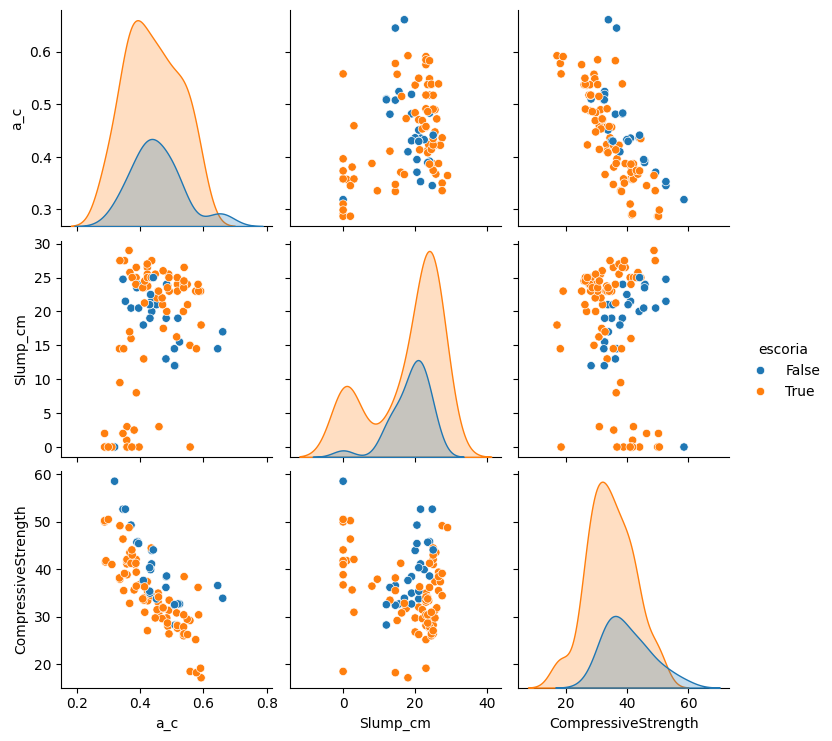

In [8]:
# Grilla de gráficos de puntos
sns.pairplot(df_hormigon[['a_c','Slump_cm','CompressiveStrength','escoria']],hue='escoria')
plt.show()

Pareciera verse que la presencia de escoria es distinguible en las variables predictoras, particularmente en el gráfico resistencia a la compresión/a-c)

#### Modelado


Nuestro objetivo final es, utilizando nuestro entendimiento del problema, modelar Y con uno o más de los predictores anteriores.

De manera similar a como hicimos en clases anteriores, tenemos que indicarle a bambi:
- Las prioris,
- El DataFrame con los datos,
- La familia: **Bernoulli** ya que Y es un indicador binario de algún evento de interés que ocurre con una cierta probabilidad
- la fórmula: igual que siempre, considerando que se aplica la transformación logit()

##### Modelo 1 (simple)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength)}}$$

In [9]:
model_1 = bmb.Model("escoria ~ scale(a_c) + scale(Slump_cm) + scale(CompressiveStrength)", df_hormigon, family="bernoulli")
fitted_1 = model_1.fit(draws=2000, chains=4)

Output()

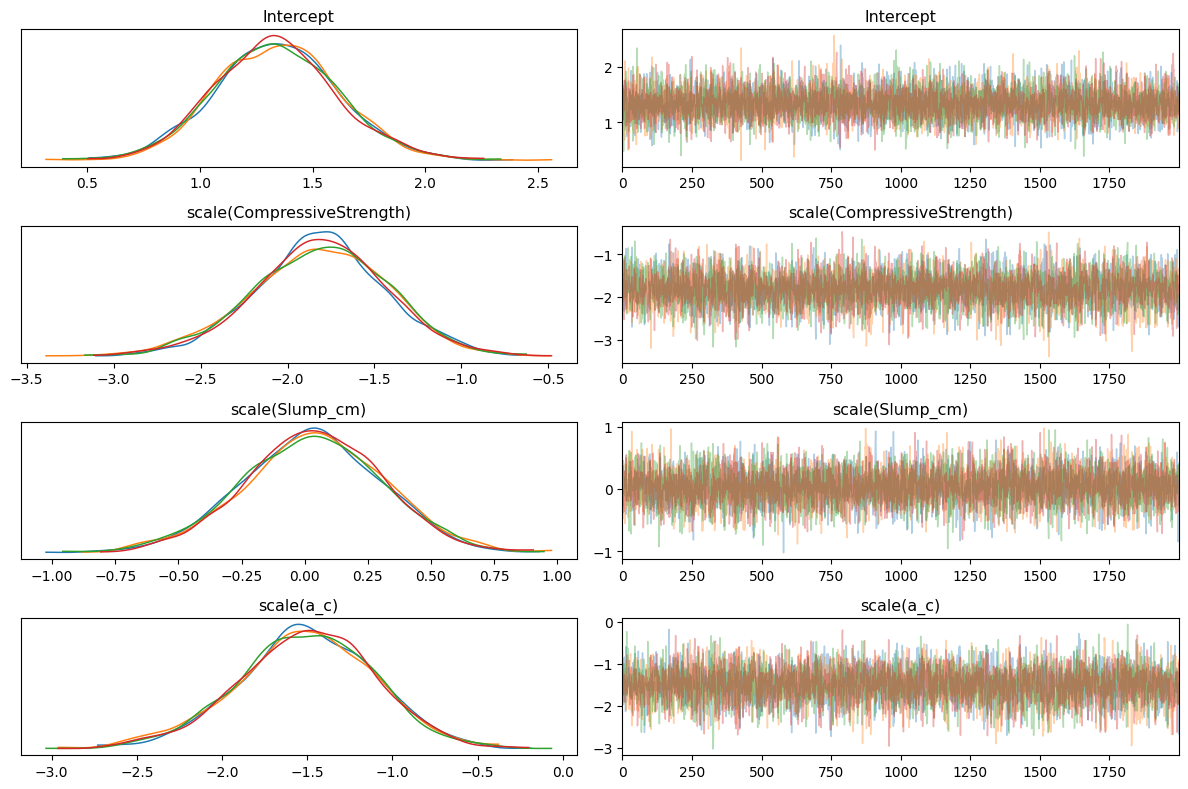

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.339,0.272,0.823,1.848,0.003,0.003,6550.0,5711.0,1.0
scale(CompressiveStrength),-1.814,0.388,-2.532,-1.053,0.005,0.004,5113.0,5083.0,1.0
scale(Slump_cm),0.033,0.277,-0.488,0.561,0.004,0.003,6180.0,5053.0,1.0
scale(a_c),-1.507,0.404,-2.291,-0.751,0.006,0.005,4741.0,5052.0,1.0


In [10]:
az.plot_trace(fitted_1,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_1)

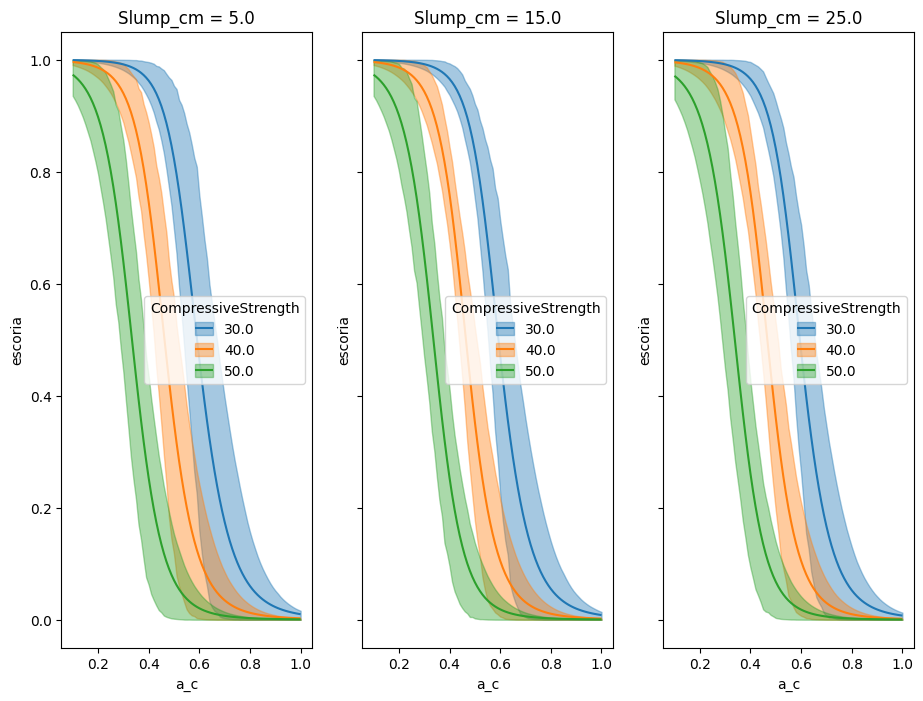

In [11]:
bmb.interpret.plot_predictions(model_1,fitted_1,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 40, 50],
                               'Slump_cm':[5,15,25]},prob=0.9,fig_kwargs=dict(figsize=(11, 8), sharey=True))
plt.show()

##### Modelo 1b (sin asentamiento)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + D \cdot CompressiveStrength \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + D \cdot CompressiveStrength)}}$$

In [12]:
model_1b = bmb.Model("escoria ~ scale(a_c) + scale(CompressiveStrength)", df_hormigon, family="bernoulli")
fitted_1b = model_1b.fit(draws=2000, chains=4)

Output()

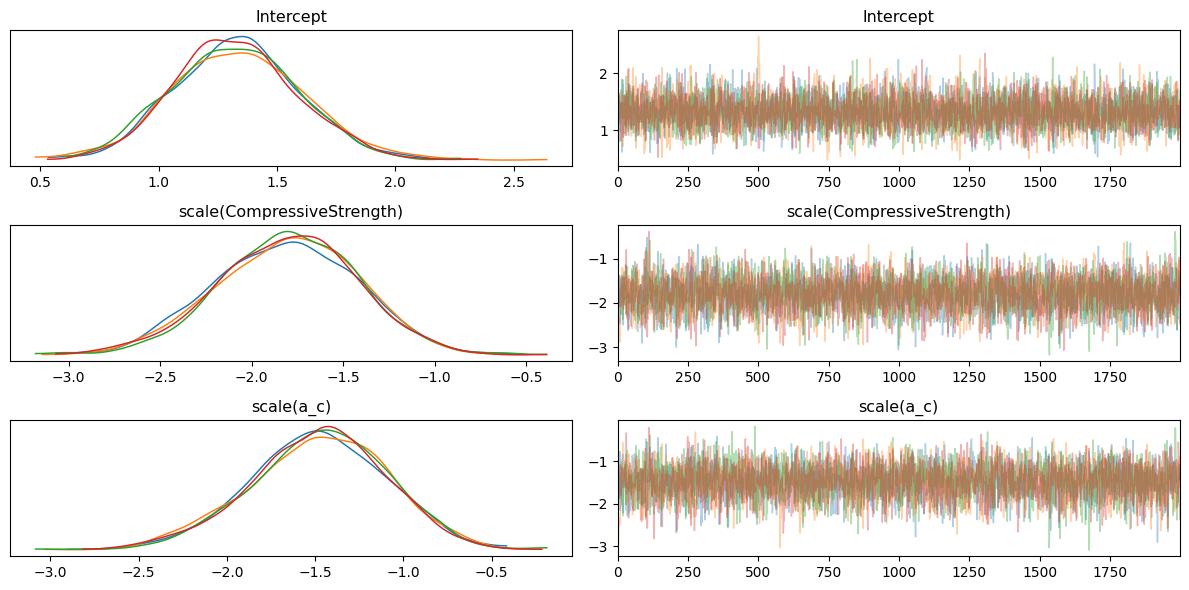

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.328,0.268,0.831,1.828,0.004,0.003,4808.0,4639.0,1.0
scale(CompressiveStrength),-1.806,0.383,-2.541,-1.115,0.006,0.004,3692.0,4446.0,1.0
scale(a_c),-1.481,0.390,-2.214,-0.751,0.006,0.004,3814.0,4094.0,1.0


In [13]:
az.plot_trace(fitted_1b,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_1b)

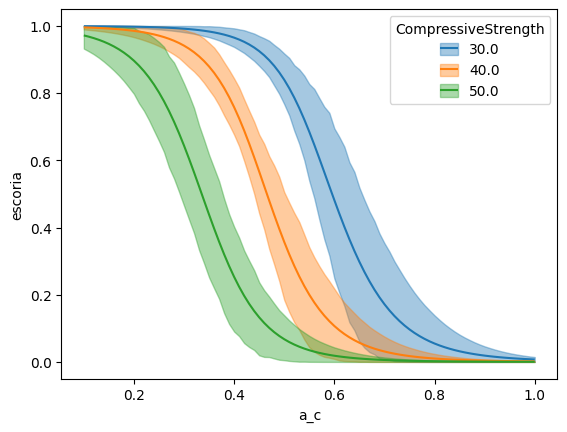

In [14]:
bmb.interpret.plot_predictions(model_1b,fitted_1b,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 40, 50]},prob=0.9)
plt.show()

##### Modelo 2 (Interacciones)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength  \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength)}}$$

In [15]:
model_2 = bmb.Model("escoria ~ scale(a_c)*scale(CompressiveStrength) + scale(Slump_cm)", df_hormigon, family="bernoulli")
fitted_2 = model_2.fit(draws=2000, chains=4)

Output()

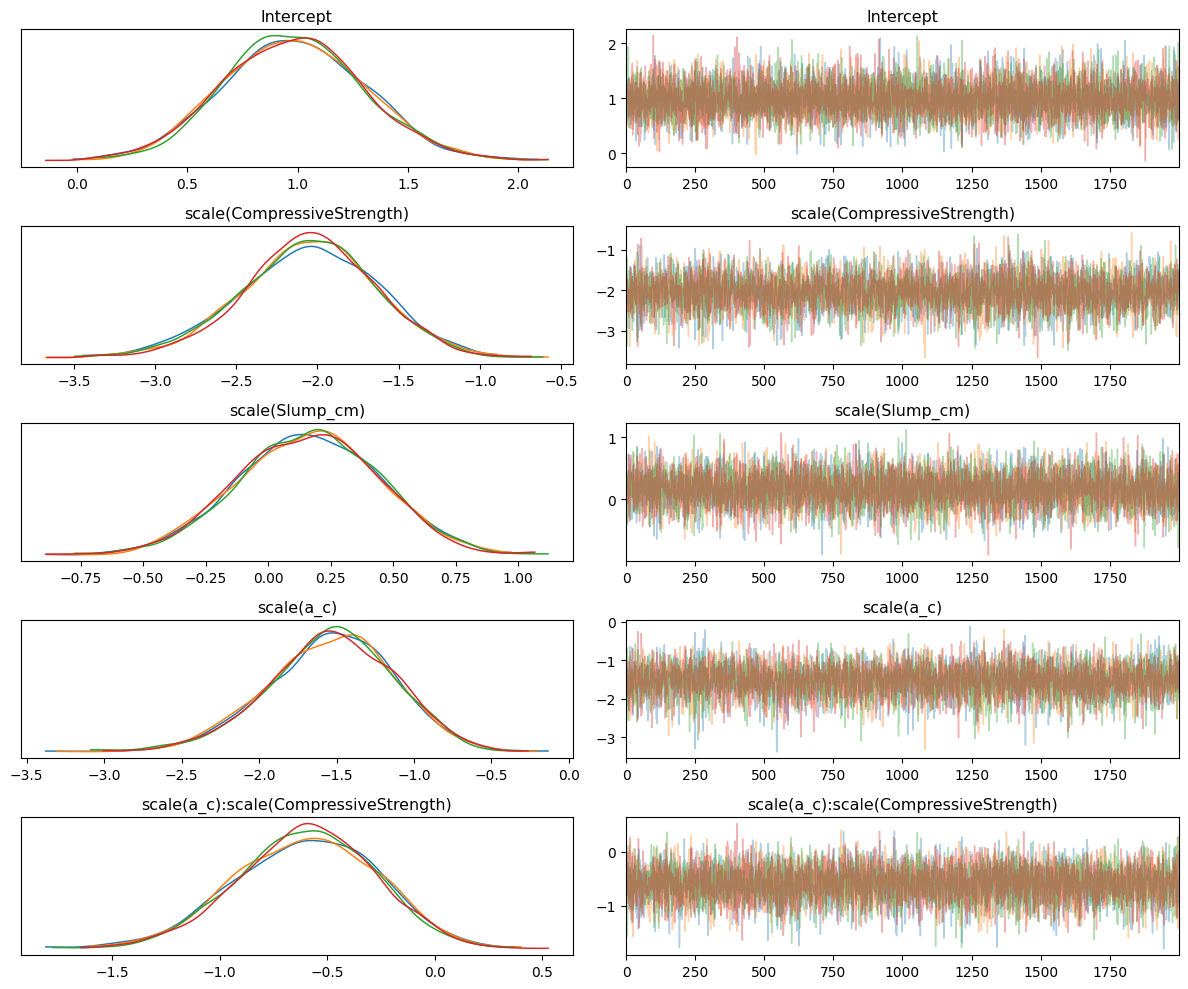

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.984,0.320,0.376,1.566,0.003,0.003,8914.0,5787.0,1.0
scale(CompressiveStrength),-2.054,0.421,-2.886,-1.289,0.006,0.005,5524.0,4996.0,1.0
scale(Slump_cm),0.162,0.281,-0.351,0.695,0.003,0.003,6557.0,5628.0,1.0
scale(a_c),-1.538,0.412,-2.291,-0.760,0.006,0.005,5585.0,5217.0,1.0
scale(a_c):scale(CompressiveStrength),-0.599,0.327,-1.200,0.019,0.004,0.004,6942.0,5780.0,1.0


In [16]:
az.plot_trace(fitted_2,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_2)

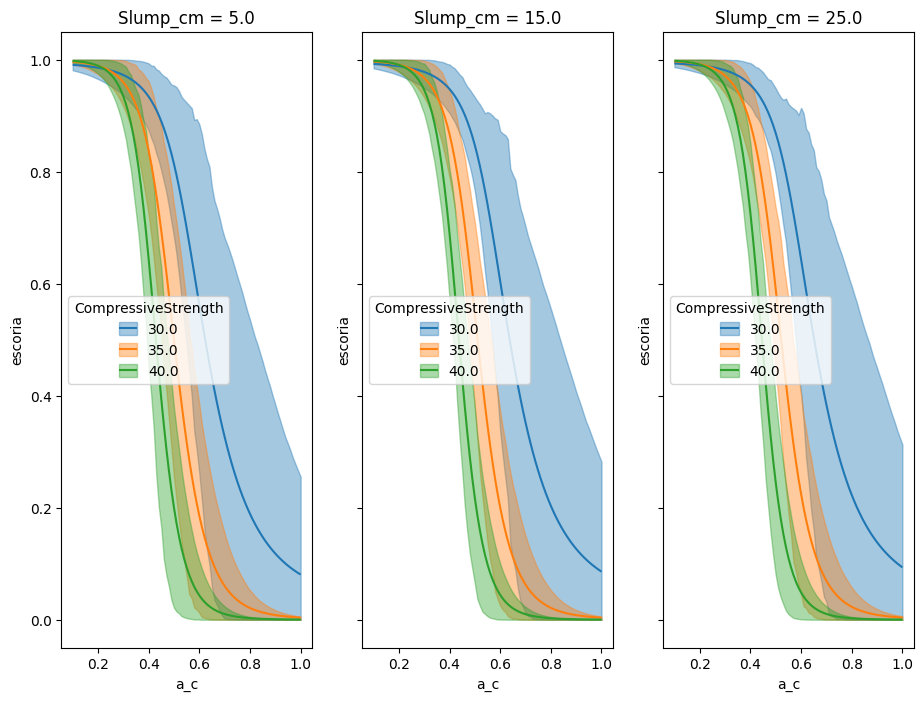

In [17]:
bmb.interpret.plot_predictions(model_2,fitted_2,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 35, 40],
                               'Slump_cm':[5,15,25]},prob=0.9,fig_kwargs=dict(figsize=(11, 8), sharey=True))
plt.show()

##### Modelo 2b (sin asentamiento)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength  \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength)}}$$

In [18]:
model_2b = bmb.Model("escoria ~ scale(a_c)*scale(CompressiveStrength)", df_hormigon, family="bernoulli")
fitted_2b = model_2b.fit(draws=2000, chains=4)

Output()

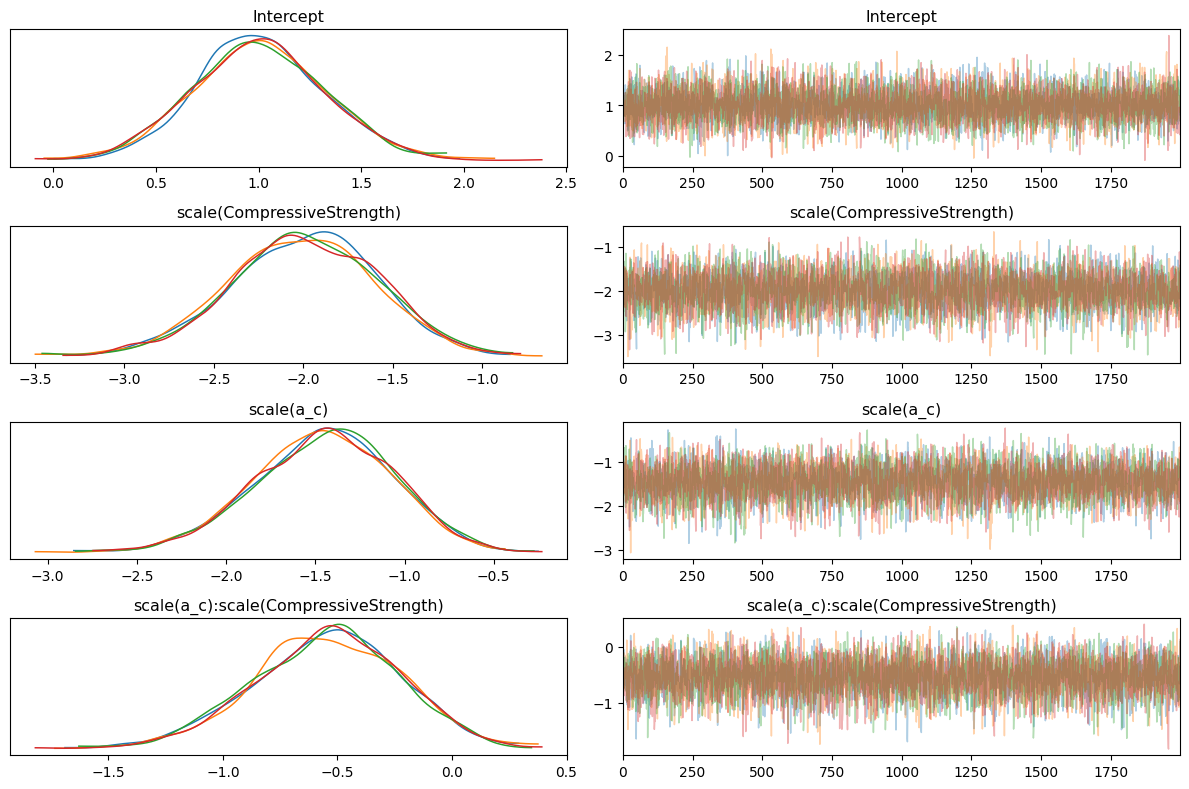

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.004,0.321,0.378,1.581,0.004,0.003,7788.0,6262.0,1.0
scale(CompressiveStrength),-2.000,0.411,-2.740,-1.200,0.006,0.005,5049.0,4951.0,1.0
scale(a_c),-1.455,0.391,-2.223,-0.755,0.005,0.004,5313.0,5322.0,1.0
scale(a_c):scale(CompressiveStrength),-0.548,0.323,-1.181,0.027,0.004,0.003,6145.0,5182.0,1.0


In [19]:
az.plot_trace(fitted_2b,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_2b)

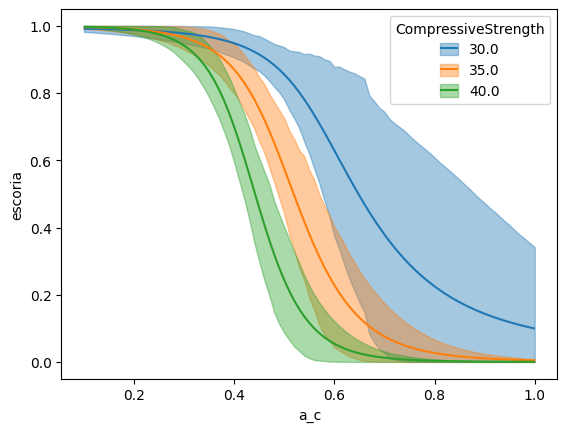

In [20]:
bmb.interpret.plot_predictions(model_2b,fitted_2b,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 35, 40]},prob=0.9)
plt.show()

##### Modelo 3 (logaritmos)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot \log(a\_c) + C \cdot Slump\_cm+ D \cdot \log(CompressiveStrength) \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot \log(a\_c) + C \cdot Slump\_cm+ D \cdot \log(CompressiveStrength))}}$$

In [21]:
model_3 = bmb.Model("escoria ~ scale(Slump_cm) + scale(log(a_c)) + scale(log(CompressiveStrength))", df_hormigon, family="bernoulli")
fitted_3 = model_3.fit(draws=2000, chains=4)

Output()

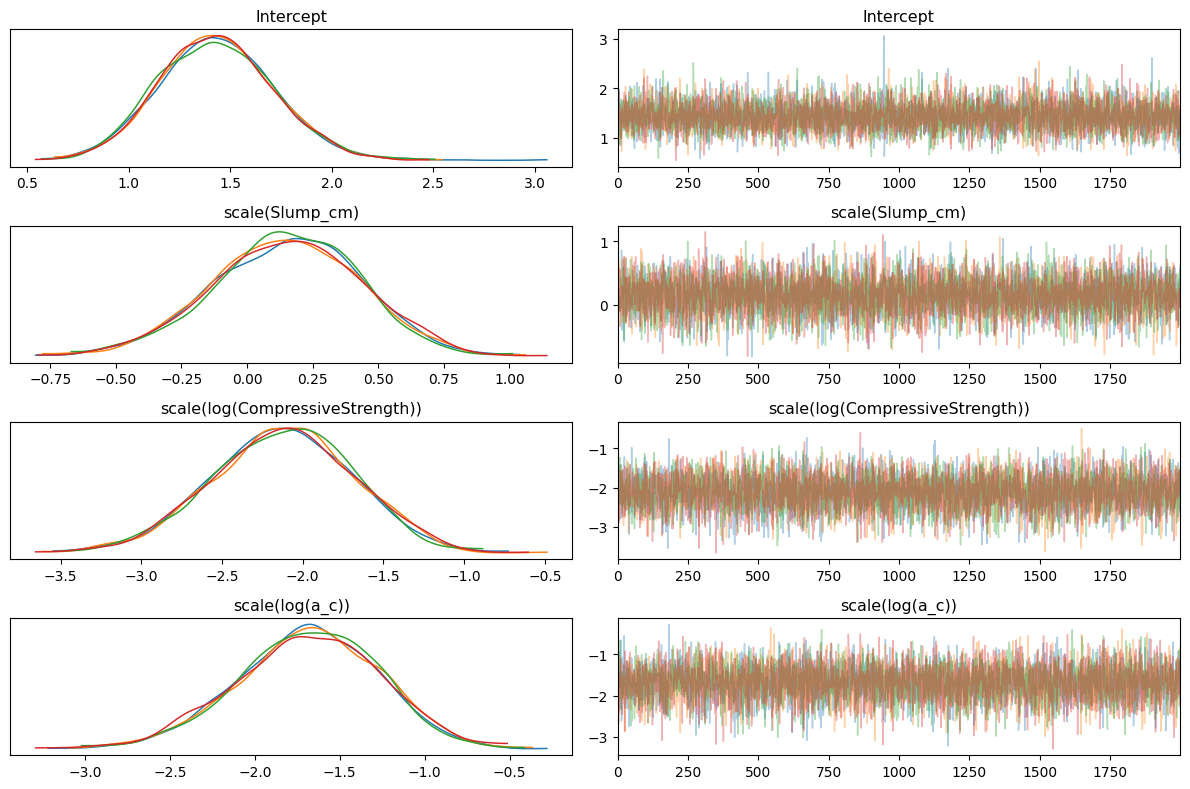

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.432,0.281,0.902,1.952,0.004,0.003,5884.0,5259.0,1.0
scale(Slump_cm),0.151,0.282,-0.377,0.678,0.004,0.003,5836.0,5490.0,1.0
scale(log(CompressiveStrength)),-2.124,0.437,-2.975,-1.346,0.006,0.004,5126.0,5738.0,1.0
scale(log(a_c)),-1.687,0.419,-2.479,-0.915,0.006,0.004,5063.0,5382.0,1.0


In [22]:
az.plot_trace(fitted_3,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_3)

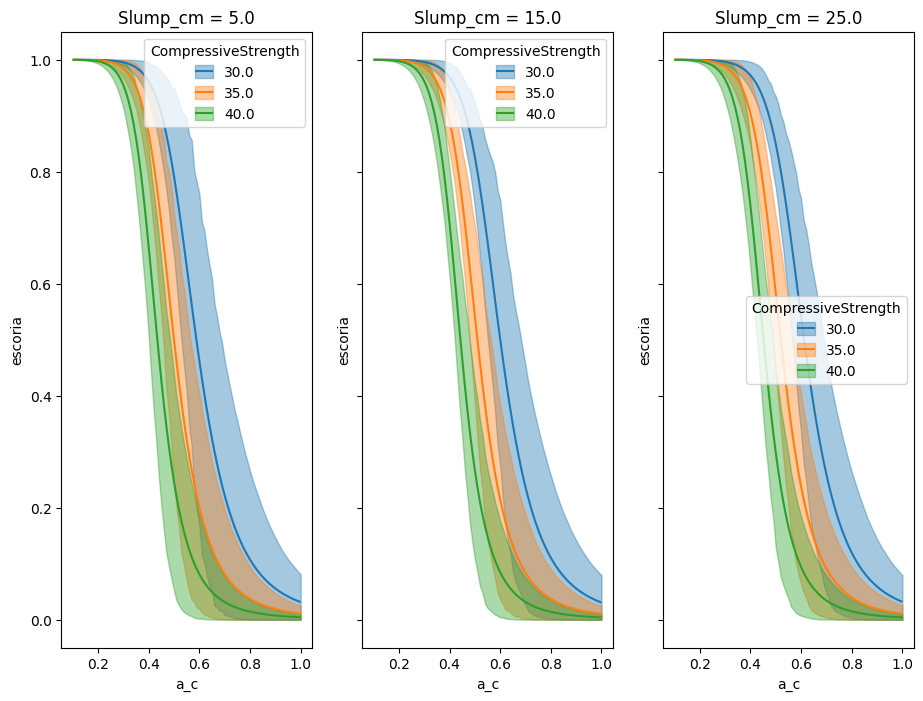

In [23]:
bmb.interpret.plot_predictions(model_3,fitted_3,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 35, 40],
                               'Slump_cm':[5,15,25]},prob=0.9,fig_kwargs=dict(figsize=(11, 8), sharey=True))
plt.show()

##### Modelo 3b (sin asentamiento)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot \log(a\_c) + D \cdot \log(CompressiveStrength) \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot \log(a\_c) + D \cdot \log(CompressiveStrength))}}$$

In [24]:
model_3b = bmb.Model("escoria ~ scale(log(a_c)) + scale(log(CompressiveStrength))", df_hormigon, family="bernoulli")
fitted_3b = model_3b.fit(draws=2000, chains=4)

Output()

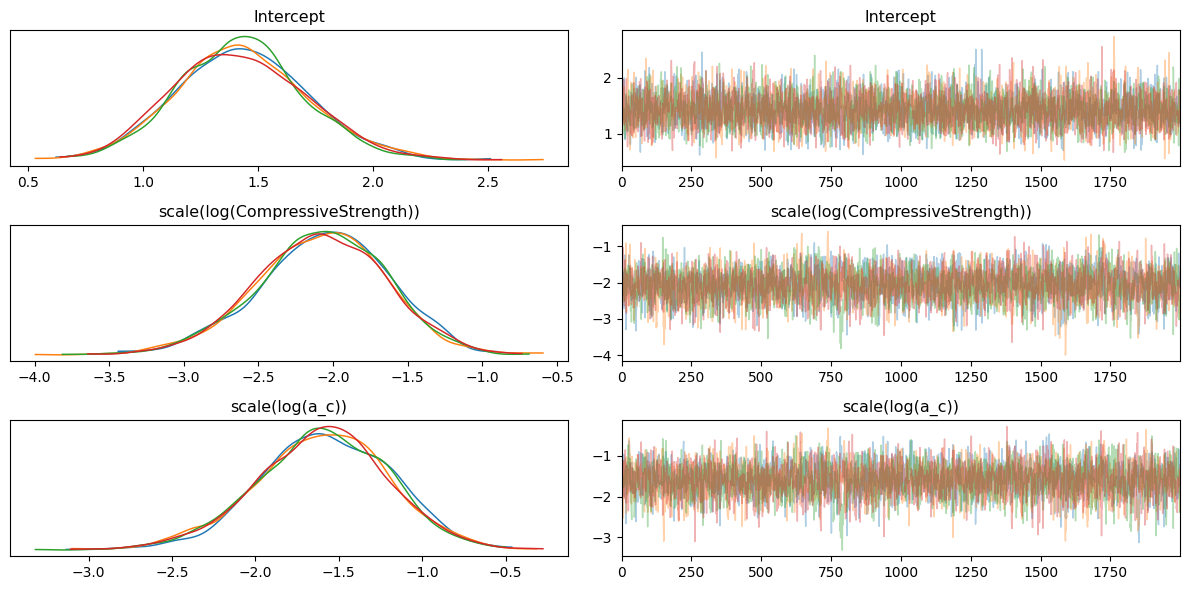

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.428,0.284,0.879,1.948,0.004,0.003,4509.0,4641.0,1.0
scale(log(CompressiveStrength)),-2.078,0.435,-2.935,-1.295,0.008,0.006,3144.0,3664.0,1.0
scale(log(a_c)),-1.597,0.398,-2.397,-0.896,0.007,0.005,3318.0,3909.0,1.0


In [25]:
az.plot_trace(fitted_3b,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_3b)

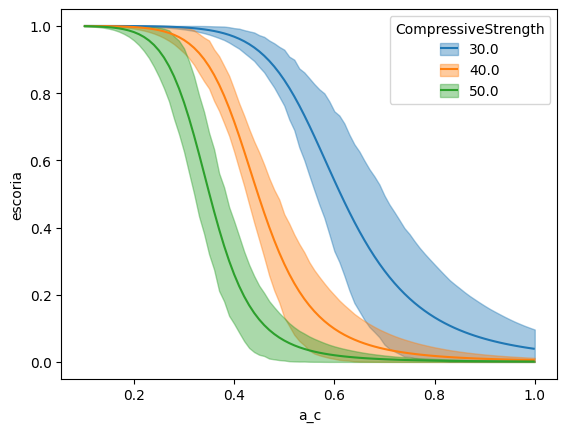

In [26]:
bmb.interpret.plot_predictions(model_3b,fitted_3b,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 40, 50]},prob=0.9)
plt.show()

#### Comparando los modelos

Como ya vimos, con `Arviz` podemos comparar la capacidad predictiva 'out-of-sample' estimada de los modelos para elegir:

In [27]:
model_1.compute_log_likelihood(fitted_1)
model_2.compute_log_likelihood(fitted_2)

model_1b.compute_log_likelihood(fitted_1b)
model_2b.compute_log_likelihood(fitted_2b)

model_3.compute_log_likelihood(fitted_3)
model_3b.compute_log_likelihood(fitted_3b)

models_dict = {
    "model_1": fitted_1,
    "model_2": fitted_2,
    "model_1b": fitted_1b,
    "model_2b": fitted_2b,
    "model_3": fitted_3,
    "model_3b": fitted_3b}

df_compare = az.compare(models_dict)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_3b,0,-42.425351,2.153035,0.000000,1.000000e+00,4.713828,0.000000,False,log
model_3,1,-42.694179,2.638747,0.268829,5.051515e-15,4.683991,0.397982,False,log
model_2b,2,-43.447177,2.974443,1.021826,0.000000e+00,4.983037,0.711272,False,log
model_2,3,-43.661003,3.462800,1.235652,0.000000e+00,4.953134,0.777935,False,log
model_1b,4,-44.493456,2.147258,2.068105,0.000000e+00,4.939419,0.899080,False,log
model_1,5,-45.216221,2.737175,2.790870,0.000000e+00,4.976249,0.949374,False,log


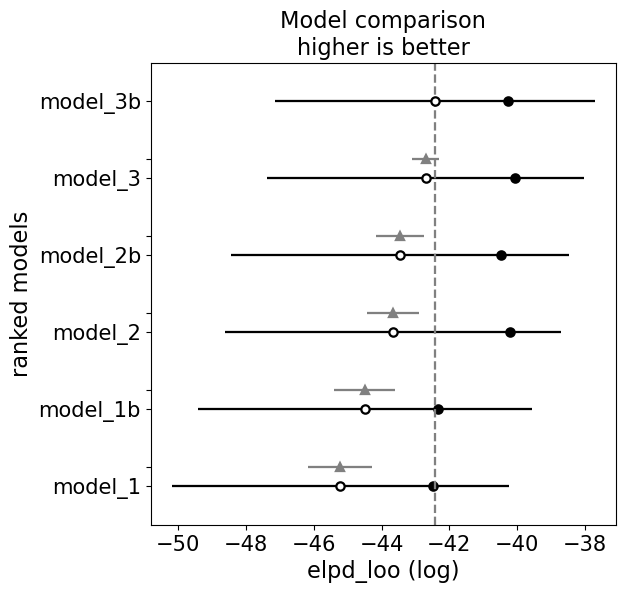

In [28]:
az.plot_compare(df_compare, insample_dev=True,plot_ic_diff=True);

Y con esto podríamos elegir un modelo entre los que planteamos. ¿Cuál usarían ustedes?

#### Uso del modelo

Ahora que tenemos un modelo, podemos usarlo para predecir la presencia de escoria, y también para analizar un poco mejor cómo funciona.

Para ello, igual que siempre, vamos a simular valores de probabilidad para datos no vistos.

Tomemos el siguiente hormigón hormigón:

- a/c: 0.4; fc=40MPa
- a/c: 0.5; fc=40MPa

Primero, genero un nuevo dataframe:

In [29]:
df_nuevo = pd.DataFrame({'a_c':[0.4,0.5],'CompressiveStrength':[40,40]})
df_nuevo.head()

,a_c,CompressiveStrength
0,0.4,40
1,0.5,40


Luego, predigo la probabilidad de escoria:

In [30]:
results = model_3b.predict(fitted_3b,kind='response_params',data=df_nuevo,inplace=False)
results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

¡Y simplemente grafico el histograma de simulaciones!

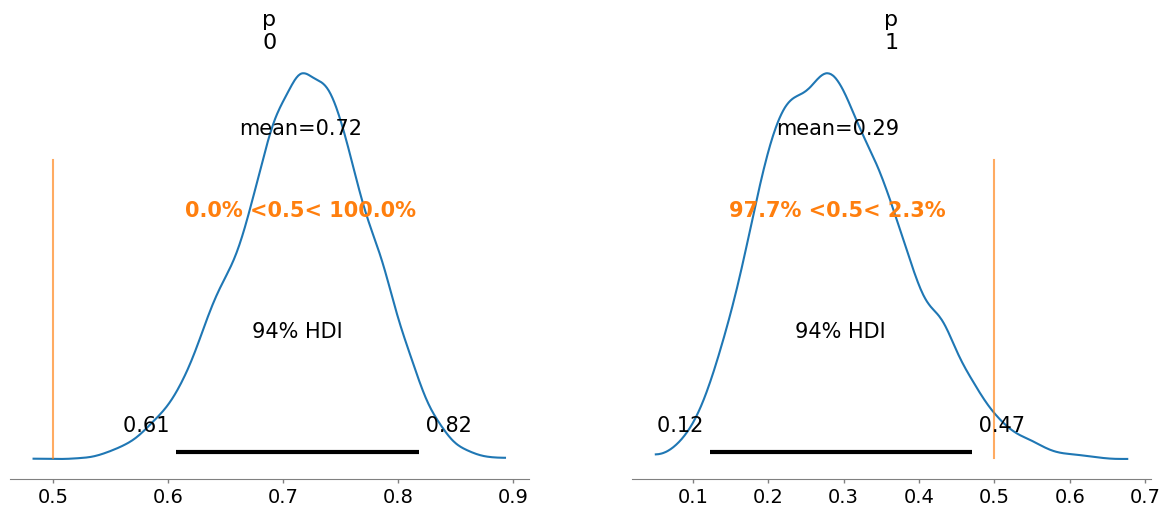

In [31]:
az.plot_posterior(results,var_names=['p'],ref_val=0.5)
plt.show()

Tengan cuidado que el modelo define probabilidades. La decisión final de "predecir o no" la presencia de escoria es una decisión del modelador (¿a partir de qué probabilidad distingo entre sí y no? La respuesta no siempre es obvia --> Medicina, detección de zonas potenciales de tornados, etc.). El criterio de decisión hay que adoptarlo en función de otras métricas (error de tipo I, tipo II, etc.).

### Otros comentarios (modelos) Finales



#### Regresión categórica (no binaria)

Hasta el momento vimos cómo modelar resultados binarios con Bambi, donde se utiliza la familia **Bernoulli**, pero en caso de querer hacerlo con un número arbitrario de resultados, la multivariada de la familia Bernoulli es la familia **categórica**.

El modelo se define de manera muy similar a lo anterior:



```
# Modelo 2 Generico:
model_2 = bmb.Model('Concrete_category ~ CompressiveStrength', data, family="categorical", priors=priors)
```



En este tipo de modelos, donde hay más de una categoría (K categorías), la cantidad de parámetros se multiplica por (K-1), porque tengo que ajutar K-1 probabilidades (la que falta sale como 1 menos la sumatoria de las demás). La Bernoulli es simplemente un caso particular donde solo hay un valor de $p$ (o función $p(x)$) a ajustar.

####Regresión ordinal (Off-Road)

Otra situación que podría presentarse es modelizar Y, que se trata de un conjunto de categorías ordenadas. En este caso, si bien nos hacemos una idea de qué categoría es mayor a otra, no podemos establecer la diferencia entre ellas, de hecho, no necesariamente deben ser equidistantes.

Supongamos que ahora, en vez de la columna con el extendido y el asentamiento, tenemos una variable categórica con la consistencia del hormigón, resultando 5 categorías según la normativa nacional:
- Seca: un asentamiento menor a 4cm.
- Plástica: entre 5 y 9cm.
- Blanda: entre 10 y 15cm.
- Fluída:entre 16 y 21cm.
- Líquida: un asentamiento mayor a 24cm

In [ ]:
df_hormigon.loc[df_hormigon['Slump_cm'] <= 4, 'Consistency'] = "Seca"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 5) & (df_hormigon['Slump_cm'] <= 9), 'Consistency'] = "Plástica"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 10) & (df_hormigon['Slump_cm'] <= 15), 'Consistency'] = "Blanda"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 16) & (df_hormigon['Slump_cm'] <= 21), 'Consistency'] = "Fluída"
df_hormigon.loc[df_hormigon['Slump_cm'] >= 24, 'Consistency'] = "Líquida"

A la columna `Consistency` la transformamos en tipo categórica e indicamos el orden de las mismas en `categories` e indicando `ordered=True`



In [ ]:
df_hormigon['Consistency'] = pd.Categorical(df_hormigon['Consistency'], categories=["Seca", "Plástica", "Blanda", "Fluída", "Líquida"], ordered=True)
df_hormigon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cement               103 non-null    float64 
 1   Slag                 103 non-null    float64 
 2   Fly_ash              103 non-null    float64 
 3   Water                103 non-null    float64 
 4   Superplasticizer     103 non-null    float64 
 5   Coarse_aggr          103 non-null    float64 
 6   Fine_aggr            103 non-null    float64 
 7   Slump_cm             103 non-null    float64 
 8   Flow_cm              103 non-null    float64 
 9   CompressiveStrength  103 non-null    float64 
 10  Strength_Category    103 non-null    category
 11  Consistency          79 non-null     category
dtypes: category(2), float64(10)
memory usage: 8.7 KB


El modelo se define de manera muy similar a lo anterior, salvo que cambian las familias:
- `family = "cumulative"` si es acumulativo
- `family = "sratio"` si es secuencial.

La diferencia entre ambos modelos es cómo construyen la idea de que una categoría es mayor a la otra. En el caso acumulativo se tiene una sola `variable latente` continua, y las categorías son límites en los valores que toma esta, mientras que el caso secuencial adopta distintas `variables latentes` entre cada categoría.

Por decirlo de alguna manera, este segundo modelo asume que la para llegar a la categoría `k+1` primero hubo que pasar por las primeras `k` categorías, mientras que el modelo acumulativo no. Este solo incorpora información de que una categoría es "mayor" a la otra y la incluye.

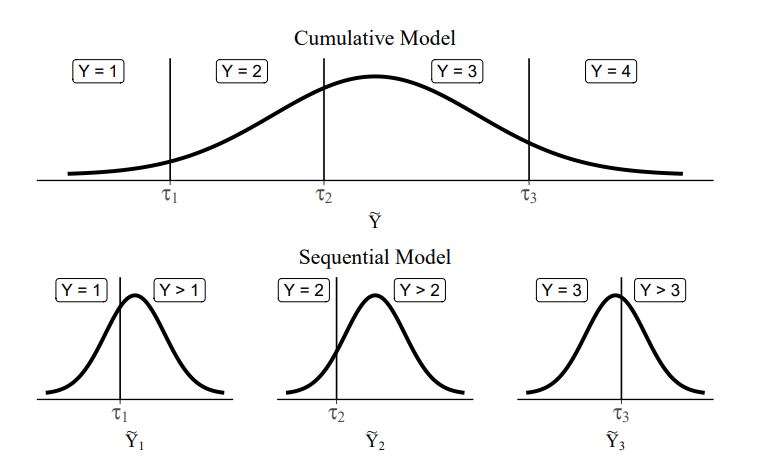

#### Regresión binomial

Es un caso particular de la logística, pero donde en vez de cargar en forma individual a los datos, lo que tengo es cantidades. Por ejemplo, datos de #hombres en bicicleta sobre #TOTAL.

El modelo ajusta $p$ la proporción de hombres o la probabilidad de que un cicliste sea hombre, cargándolo de la siguiente manera con la familia `binomial`

```
model_non_hierarchical = bmb.Model("p(H, T) ~ 0 + Dia_semana", df, family="binomial")
model_non_hierarchical
```


#### Regresión poisson

Por último, también puede ajustarse un modelo de poisson, donde el $\lambda$ depende una variable predictora (por ejemplo, la magnitud del sismo $M$). Este es el caso de la ley de Guttenberg-Richter:

$$\#sismos \sim poisson(\lambda)$$

$$\log(\lambda) = A + B\ M$$

```
model_poisson = bmb.Model(sismos ~ 1 + M", df, family="poisson")
model_poisson
```

#### En fin

A fin de cuentas, todo lo que vimos para modelos normales aplica a otras funciones de verosimilutd, como por ejemplo un modelo de bernoulli (lo que nos llevó a una regresión logística). La carga del modelo en general es siempre igual cambiando `family`, y la forma de interpretar (o entender efectos) también, con pequeñas particularidades según el caso.